In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


## Classifcation : The MNIST Dataset

#### Import the MNIST dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# Download and load the train and test dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

3.3%

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


10.9%%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


180.4%/Users/cecilerousseau/anaconda3/envs/pytorch-deepdream/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


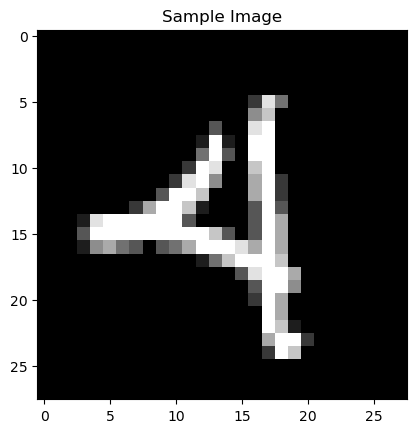

In [4]:
# Choose a sample image from the dataset
sample_loader = DataLoader(train_data, batch_size=1, shuffle=True)
sample_image, _ = next(iter(sample_loader))

# Visualize the sample image
plt.title('Sample Image')
plt.imshow(sample_image.squeeze().detach().numpy(), cmap='gray')
plt.show()

#### Creation of a Convolutional Neural Network

In [5]:
class CNN(nn.Module):
    
    def __init__(self):
        
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(32 * 7 * 7, 10) # 32*7*7 come from the size of the MNIST dataset

        self.layer_names = ['conv1_1', 'relu1_1', 'max_pooling1',
                            'conv2_1', 'relu2_1', 'max_pooling2']
        self.activations = {}

    def forward(self, x):
        
        x = self.conv1(x)
        self.activations['conv1_1'] = x
        x = self.conv1[1](x)  # ReLU layer
        self.activations['relu1_1'] = x

        x = self.conv2(x)
        self.activations['conv2_1'] = x
        x = self.conv2[1](x)  # ReLU layer
        self.activations['relu2_1'] = x

        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x  # Return both the output and the intermediate x for visualization

In [6]:
# Create a CNN model
cnn = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

In [7]:
# Train the model
def train(num_epochs, cnn, loaders):
    
    cnn.train()
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = images
            b_y = labels
            output, _ = cnn(b_x)
            loss = criterion(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

# Train the model
train(5, cnn, {'train': train_loader, 'test': test_loader})

Epoch [1/5], Step [100/600], Loss: 0.1040
Epoch [1/5], Step [200/600], Loss: 0.2256
Epoch [1/5], Step [300/600], Loss: 0.0848
Epoch [1/5], Step [400/600], Loss: 0.0388
Epoch [1/5], Step [500/600], Loss: 0.0589
Epoch [1/5], Step [600/600], Loss: 0.0843
Epoch [2/5], Step [100/600], Loss: 0.0105
Epoch [2/5], Step [200/600], Loss: 0.0486
Epoch [2/5], Step [300/600], Loss: 0.0334
Epoch [2/5], Step [400/600], Loss: 0.0247
Epoch [2/5], Step [500/600], Loss: 0.0264
Epoch [2/5], Step [600/600], Loss: 0.0446
Epoch [3/5], Step [100/600], Loss: 0.0183
Epoch [3/5], Step [200/600], Loss: 0.0717
Epoch [3/5], Step [300/600], Loss: 0.0212
Epoch [3/5], Step [400/600], Loss: 0.0585
Epoch [3/5], Step [500/600], Loss: 0.0735
Epoch [3/5], Step [600/600], Loss: 0.0360
Epoch [4/5], Step [100/600], Loss: 0.0063
Epoch [4/5], Step [200/600], Loss: 0.0333
Epoch [4/5], Step [300/600], Loss: 0.0176
Epoch [4/5], Step [400/600], Loss: 0.0586
Epoch [4/5], Step [500/600], Loss: 0.1270
Epoch [4/5], Step [600/600], Loss:

In [8]:
# Test the model
def test(cnn, test_loader):
    
    cnn.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs, _ = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))

# Test the model
test(cnn, test_loader)

Test Accuracy: 98.18%


#### Gradient Ascent and Visualization

In [10]:
def gradient_ascent(model, image, layer_name, iterations=50, lr=0.1):
    
    model.eval()
    image.requires_grad_(True)

    optimizer = optim.Adam([image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()

        output, _ = model(image)
        layer_activation = model.activations[layer_name]

        # Define a loss that encourages the maximization of the selected layer's activation
        loss = -layer_activation.mean()

        loss.backward()
        optimizer.step()
        
        image.data = torch.clamp(image.data, 0, 1)

    return image.detach()


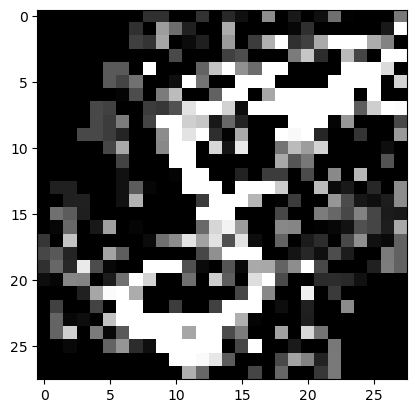

In [11]:
# Use the trained model to perform gradient ascent on a specific layer
target_layer = 'conv2_1'

# Choose a sample image from the dataset
sample_loader = DataLoader(test_data, batch_size=1, shuffle=True)
sample_image, _ = next(iter(sample_loader))

generated_image = gradient_ascent(cnn, sample_image, target_layer)

# Visualize the generated image
plt.imshow(generated_image.squeeze().detach().numpy(), cmap='gray')
plt.show()

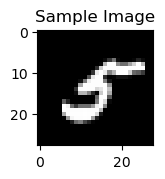

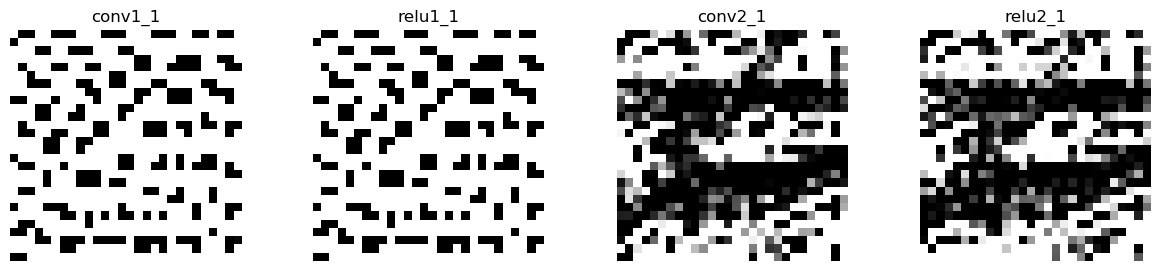

In [12]:
# Choose a sample image from the dataset
sample_loader = DataLoader(test_data, batch_size=1, shuffle=True)
sample_image, _ = next(iter(sample_loader))

# Visualize the sample image
plt.figure(figsize=(1.5,1.5))
plt.title('Sample Image')
plt.imshow(sample_image.squeeze().detach().numpy(), cmap='gray')
plt.show()

# Get layer names
# layer_names = cnn.layer_names
layer_names = ['conv1_1', 'relu1_1', 'conv2_1', 'relu2_1']

# Set up subplots
num_layers = len(layer_names)
fig, axes = plt.subplots(1, num_layers, figsize=(15, 3))

for k in range(num_layers):
    # Use the trained model to perform gradient ascent on a specific layer
    target_layer = layer_names[k]
    generated_image = gradient_ascent(cnn, sample_image, target_layer)

    # Visualize the generated image in the subplot
    axes[k].imshow(generated_image.squeeze().detach().numpy(), cmap='gray')
    axes[k].set_title(target_layer)
    axes[k].axis('off')

plt.show()

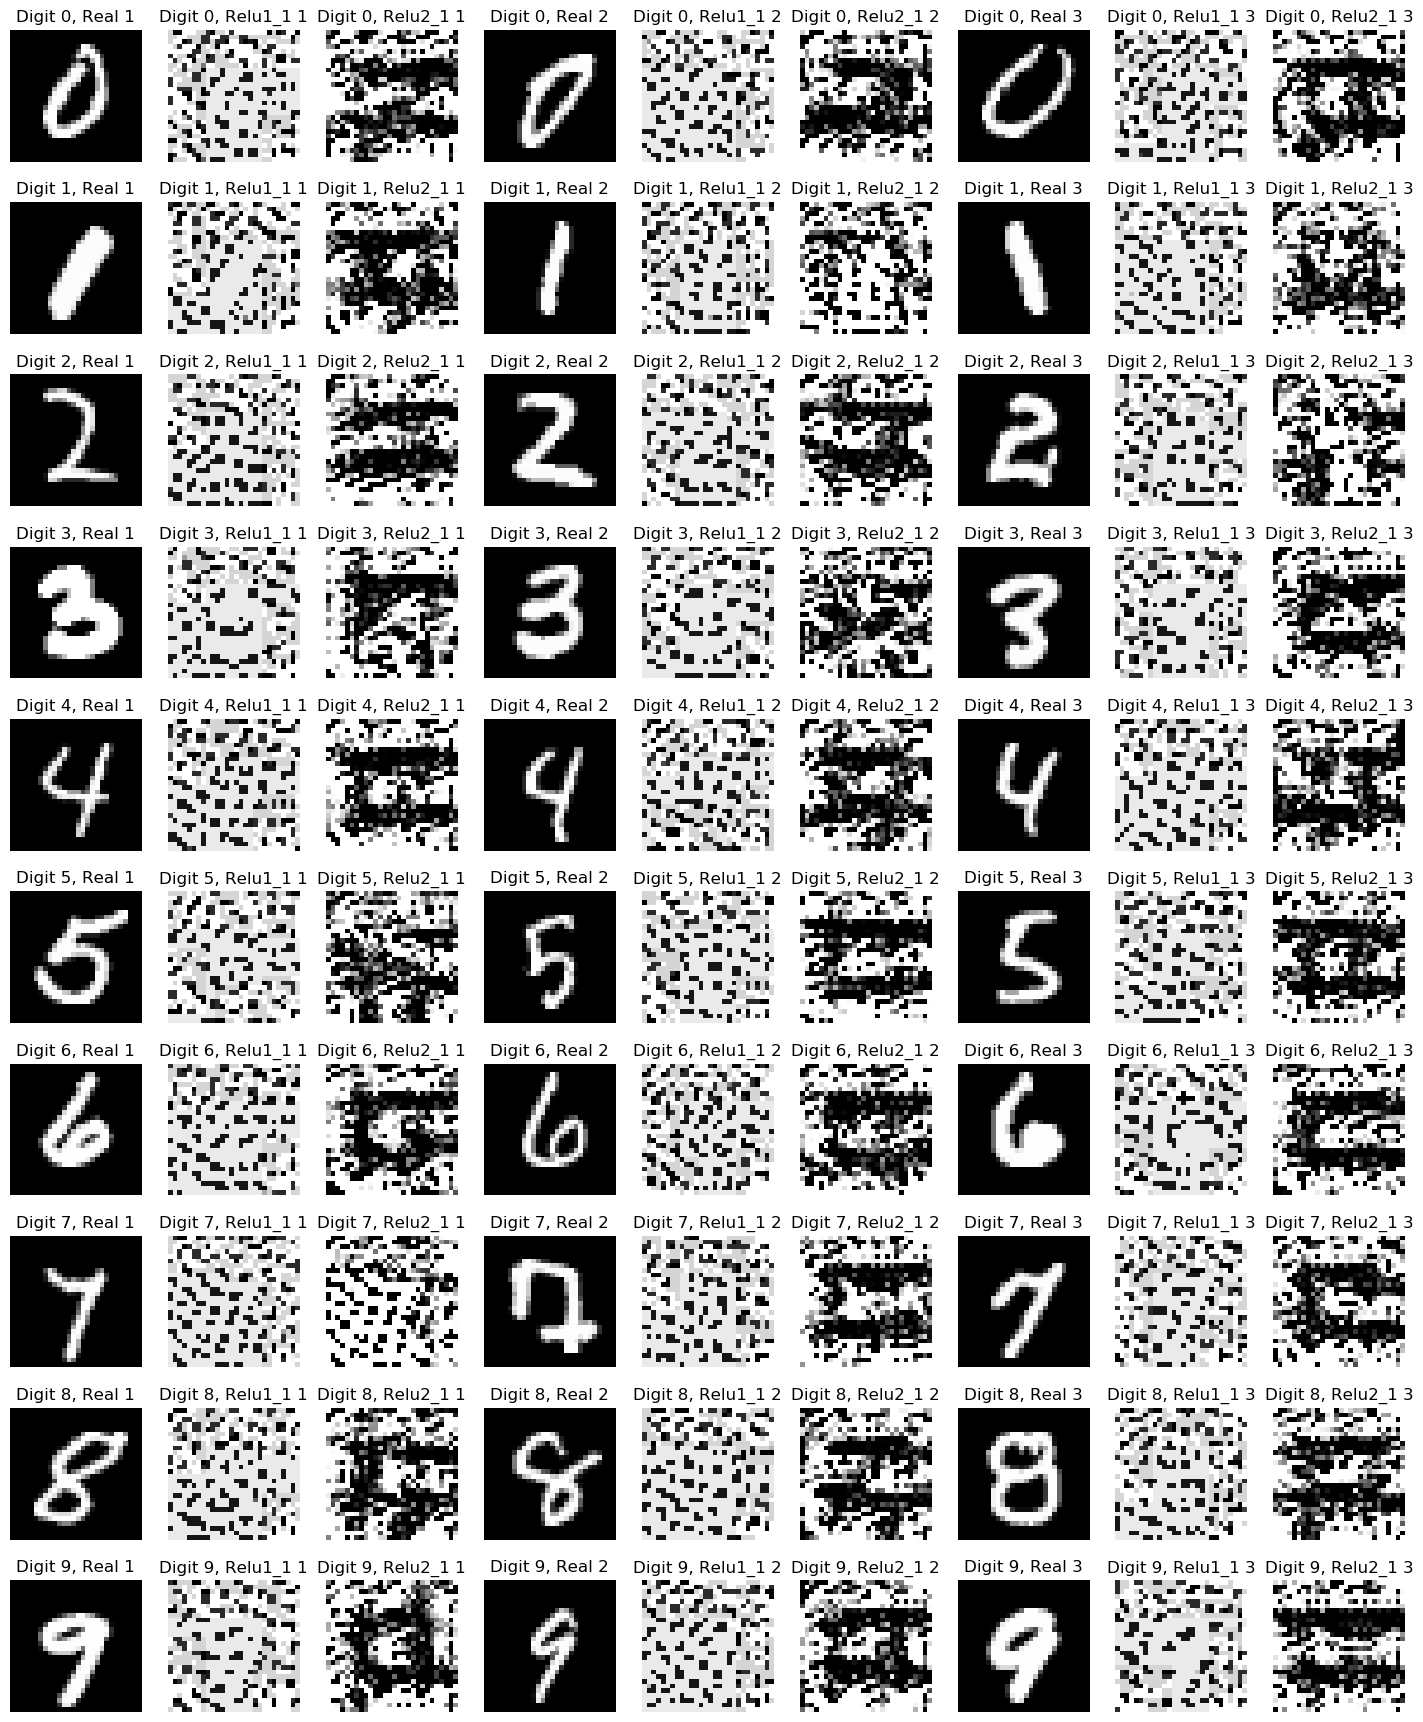

In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader

# Assuming you have the necessary functions like 'gradient_ascent' and 'cnn' defined

# Set up subplots in a 10x9 grid
fig, axes = plt.subplots(10, 9, figsize=(18, 22))

# Iterate over each digit (from 0 to 9)
for digit_to_sample in range(10):
    # Choose a sample loader for the digit
    digit_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    
    # Collect real images for the digit
    real_images = []
    for _ in range(3):
        sample_image, sample_label = next(iter(digit_loader))
        while sample_label.item() != digit_to_sample:
            sample_image, sample_label = next(iter(digit_loader))
        real_images.append(sample_image)
    
        # Iterate over each column for the current digit
    for j in range(3):
        # Visualize real images
        axes[digit_to_sample, j * 3].imshow(real_images[j].squeeze().detach().numpy(), cmap='gray')
        axes[digit_to_sample, j * 3].set_title(f'Digit {digit_to_sample}, Real {j + 1}')
        axes[digit_to_sample, j * 3].axis('off')
    
    # Collect gradient ascent images for 'relu1_1'
    relu1_1_images = [gradient_ascent(cnn, sample_image, 'relu1_1') for sample_image in real_images]

    # Collect gradient ascent images for 'relu2_1'
    relu2_1_images = [gradient_ascent(cnn, sample_image, 'relu2_1') for sample_image in real_images]

    # Iterate over each column for the current digit
    for j in range(3):

        # Visualize gradient ascent images for 'relu1_1'
        axes[digit_to_sample, j * 3 + 1].imshow(relu1_1_images[j].squeeze().detach().numpy(), cmap='gray')
        axes[digit_to_sample, j * 3 + 1].set_title(f'Digit {digit_to_sample}, Relu1_1 {j + 1}')
        axes[digit_to_sample, j * 3 + 1].axis('off')

        # Visualize gradient ascent images for 'relu2_1'
        axes[digit_to_sample, j * 3 + 2].imshow(relu2_1_images[j].squeeze().detach().numpy(), cmap='gray')
        axes[digit_to_sample, j * 3 + 2].set_title(f'Digit {digit_to_sample}, Relu2_1 {j + 1}')
        axes[digit_to_sample, j * 3 + 2].axis('off')

plt.show()


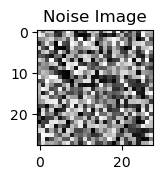

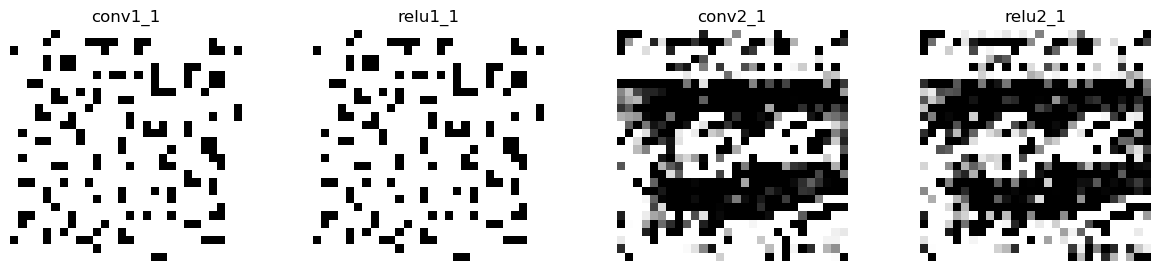

In [14]:
# Function to generate random noise image
def generate_noise_image(size):
    return torch.rand(size)

# Example usage
input_size = (1, 1, 28, 28)  # Assuming input data size is (batch_size, channels, height, width)
noise_image = generate_noise_image(input_size)

# Visualize the sample image
plt.figure(figsize=(1.5,1.5))
plt.title('Noise Image')
plt.imshow(noise_image.squeeze().detach().numpy(), cmap='gray')
plt.show()

# Get layer names
# layer_names = cnn.layer_names
layer_names = ['conv1_1', 'relu1_1', 'conv2_1', 'relu2_1']

# Set up subplots
num_layers = len(layer_names)
fig, axes = plt.subplots(1, num_layers, figsize=(15, 3))

for k in range(num_layers):
    # Use the trained model to perform gradient ascent on a specific layer
    target_layer = layer_names[k]
    generated_image = gradient_ascent(cnn, noise_image, target_layer)

    # Visualize the generated image in the subplot
    axes[k].imshow(generated_image.squeeze().detach().numpy(), cmap='gray')
    axes[k].set_title(target_layer)
    axes[k].axis('off')

plt.show()

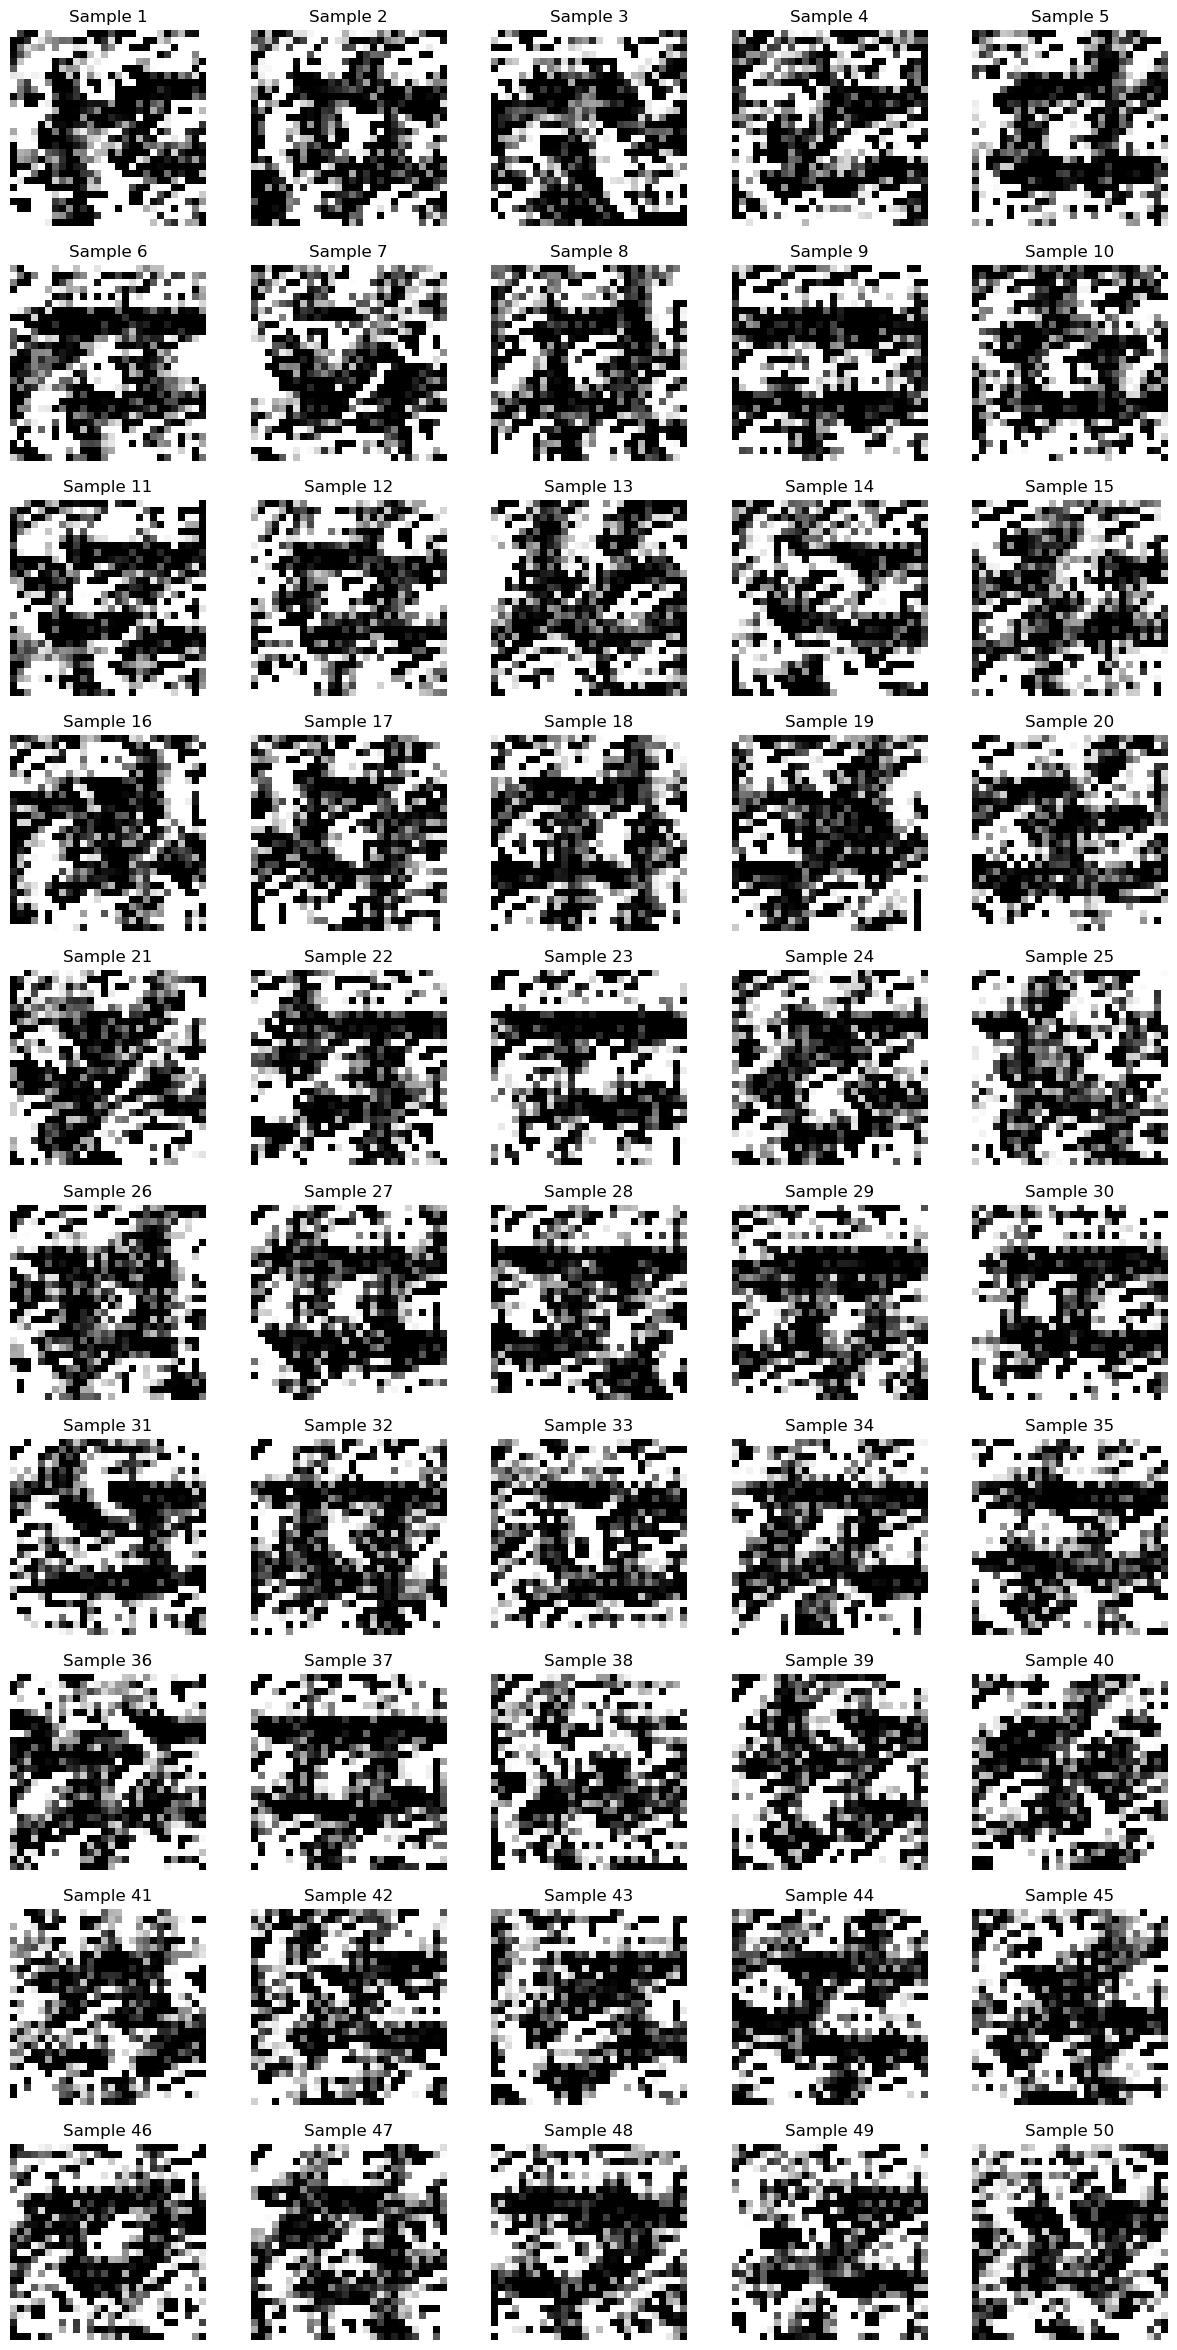

In [15]:
# Function to generate random noise image
def generate_noise_image(size):
    return torch.rand(size)

# Example usage
input_size = (1, 1, 28, 28)  # Assuming input data size is (batch_size, channels, height, width)

digit_noise_images = []

# Collect 50 samples of the digit 
for _ in range(50):
    noise_image = generate_noise_image(input_size)
    digit_noise_images.append(noise_image)

# Set up subplots in a 5x10 grid
fig, axes = plt.subplots(10, 5, figsize=(15, 30))

# Use the trained model to perform gradient ascent on 'conv2_1' for each digit '0'
for i in range(10):
    for j in range(5):
        sample_image = digit_noise_images[i * 5 + j]
        generated_image = gradient_ascent(cnn, sample_image, 'relu2_1')

        # Visualize the generated image in the subplot
        axes[i, j].imshow(generated_image.squeeze().detach().numpy(), cmap='gray')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
        axes[i, j].axis('off')

plt.show()
